# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

!unzip -q data.zip

--2023-12-07 10:39:17--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-07 10:39:17--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2023-12-07 10:39:18 (298 MB/s) - ‘data.zip.1’ saved [38392108/38392108]

replace data/class_dict? [y]es, [n]o, [

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        class_name = class_dict[member[0].text]
        xmin = int(member[4][0].text)
        ymin = int(member[4][1].text)
        xmax = int(member[4][2].text)
        ymax = int(member[4][3].text)
        res = [xmin, ymin, xmax, ymax, class_name]
        bboxes.append(res)
    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib) +
        # И откатить нормализацию (просто обратное преобразование) +
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv +

        ax.imshow(images[i].permute(1, 2, 0).mul_(torch.tensor(std)).add_(torch.tensor(mean)))

        for bbox in bboxes[i]:
            xy = (bbox[0], bbox[1])
            ax.add_patch(Rectangle(xy, bbox[2] - bbox[0], bbox[3] - bbox[1], edgecolor = 'red', facecolor = 'none'))
            ax.text(bbox[0], bbox[1], train_ds.class_dict_inv[bbox[4]], ha='left',
                    va='bottom', c='red')
    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:


![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

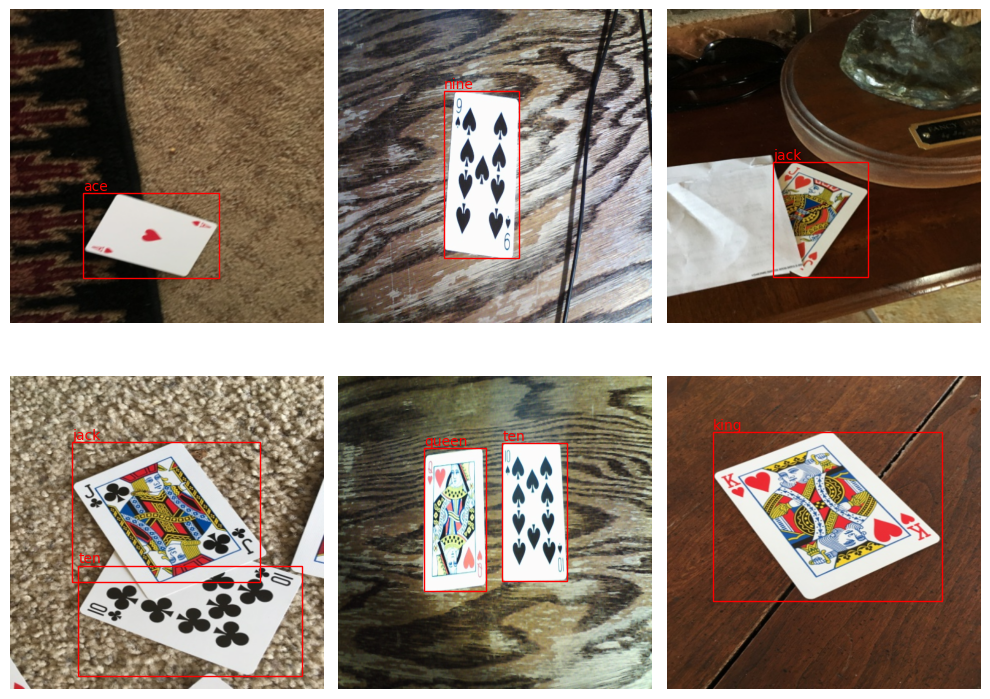

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO

Сейчас нам предстоить реализовать YOLO детектор. Это один из самых простых детекторов с точки зрения реализации. Он описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Мы будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16. В каждом пикселе мы будем предсказывать размеры прямоугольника и класс.



We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности. В каналах у нас будут записаны координаты центра, центр относительно координат пикселя, бинарная переменная (детекция присутствует), класс детекции.


In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = xmax - xmin
        y_cell = ymax - ymin
        w_box = x_cell / w
        h_box = y_cell / h

        # Посчитайте координаты центра и сдвиги
        cx = (xmax + xmin) / 2 # TODO (координаты центра в исходных координатах)
        cy = (ymax + ymin) / 2 # TODO
        cx_idx = (cx // downsample).to(torch.long)
        cy_idx = (cy // downsample).to(torch.long)

        cx_box =  (cx - cx_idx * downsample) / downsample # TODO (посчитайте сдивиги относительно cx_idx)
        cy_box =  (cy - cy_idx * downsample) / downsample # TODO

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

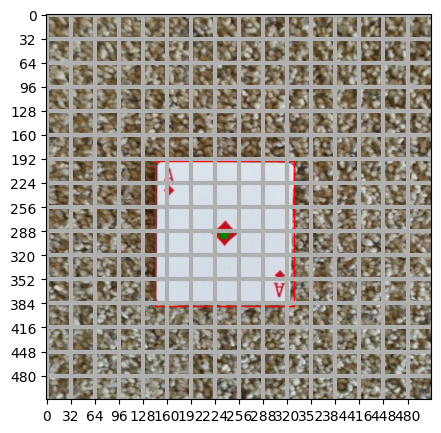

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Реализуйте аналогичные принципы, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами.

То есть, нужно проделать операции из collate_fn в обратную сторону.

In [11]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    res = []
    for i in range(b):
        bboxes = []
        for j in range(h):
            for f in range(w):
                pred_ = pred[i, :, j, f]
                if pred_[4] > threshold:
                    cx = (pred_[0] + f) * upsample
                    cy = (pred_[1] + j) * upsample
                    w_box =  pred_[2] * img_w
                    h_box =  pred_[3] * img_h
                    xmin = cx - (w_box / 2)
                    ymin = cy - (h_box / 2)
                    xmax = cx + (w_box / 2)
                    ymax = cy + (h_box / 2)
                    class_nm = pred_[5:].numpy()
                    bboxes.append((xmin, ymin, xmax, ymax, np.argmax([class_nm])))
        res.append(bboxes)
    return res

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 вклюяительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [12]:
C = 6  # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        ### YOUR CODE HERE ###
        self.resnet_layers = nn.Sequential(*list(self.model.children())[:-2])
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=3, padding = 1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding = 1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=6+5, kernel_size=3, padding = 1),
            torch.nn.Sigmoid()
        )
    def forward(self, img):
        ### YOUR CODE HERE ###
        x = self.resnet_layers(img)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [13]:
def special_loss(pred, target, check=False, C=C):
    ### YOUR CODE HERE ###
    mask = target[:, 4] == 1
    MSE_loss = nn.MSELoss(reduction='sum')
    CE_loss = nn.CrossEntropyLoss(reduction = 'sum')
    BCE_loss = nn.BCELoss(reduction = 'sum')

    tnsrs = []
    for i in range(5, 5 + C):
        tnsrs.append(torch.masked_select(pred[:, i], mask))
    pred_stack = torch.stack((tnsrs))

    localization_loss = MSE_loss(torch.masked_select(pred[:, 0], mask),
                                 torch.masked_select(target[:, 0], mask)) + \
                                 MSE_loss(torch.masked_select(pred[:, 1], mask),
                                          torch.masked_select(target[:, 1], mask))

    box_loss = MSE_loss(torch.masked_select(torch.sqrt(pred[:, 2]), mask),
                        torch.masked_select(torch.sqrt(target[:, 2]), mask)) + \
                        MSE_loss(torch.masked_select(torch.sqrt(pred[:, 3]), mask),
                                 torch.masked_select(torch.sqrt(target[:, 3]), mask))

    confidence_loss = 1.0 * BCE_loss(torch.masked_select(pred[:, 4], mask),
                                     torch.masked_select(target[:, 4], mask)) + \
                                     0.1 * BCE_loss(torch.masked_select(pred[:, 4], ~mask),
                                                    torch.masked_select(target[:, 4], ~mask))

    classification_loss = CE_loss(pred_stack.T, torch.masked_select(target[:, 5], mask).long())

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [14]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [15]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  25 # потестила, вдруг лучше бы стало
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###
        X = batch['image'].to(device)
        y = batch['target'].to(device)
        output = model(X)
        loss = special_loss(output, y, False, 6)
        epoch_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 99.144;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 44.727;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 36.580;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 33.072;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 32.024;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 31.055;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 29.828;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 29.467;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 27.690;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 26.403;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 25.888;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 25.555;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 25.552;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 25.240;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 24.999;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15 done; Train loss 24.705;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16 done; Train loss 25.317;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17 done; Train loss 24.925;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18 done; Train loss 25.742;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19 done; Train loss 24.973;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20 done; Train loss 25.376;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21 done; Train loss 25.870;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22 done; Train loss 26.337;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23 done; Train loss 26.717;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24 done; Train loss 25.041;


Запустим обученный детектор на тестовых изображениях:

In [17]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [18]:
# Нужно сделать предсказание и переложить результат на cpu

### YOUR CODE HERE ###
pbar = tqdm(test_loader, leave=False)
with torch.no_grad():
    pred = torch.empty(0).to(device)
    for batch in pbar:
        image = batch['image'].to(device)
        pred_new = model(image)
        pred = torch.cat((pred, pred_new), 0)
output = pred.cpu()

  0%|          | 0/7 [00:00<?, ?it/s]

Поскольку вывести надо не так много картинок, я решила для иллюстрации показать результат по одному батчу

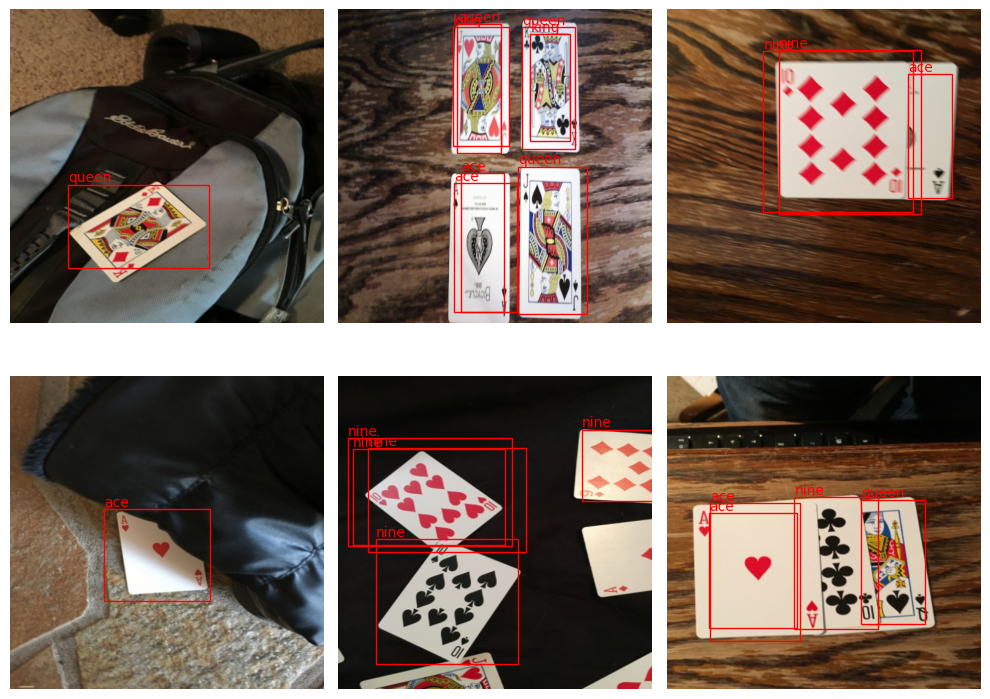

In [19]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)
with torch.no_grad():
    out = model(batch['image'].to(device)).cpu()
visualize(batch['image'], decode_prediction(out, threshold = 0.15))

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

Да, результат не идеальный, но я так долго мучила эту часть, что ему очень рада. Не судите строго, пожалуйста

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [20]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.4/659.4 kB 11.6 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [21]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [22]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    bboxes_new = []
    for bbox in bboxes:
        bbox_str = ' '.join(list(map(str, [bbox[-1], (bbox[0] + bbox[2]) / (2 * w_im), (bbox[1] + bbox[3]) / (2 * h_im), (bbox[2] - bbox[0]) / w_im, (bbox[3] - bbox[1]) / h_im])))
        bboxes_new.append(bbox_str)
    return bboxes_new

In [23]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [24]:
# Собираем YAML

nc =  6 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(train_ds.class_dict_inv.values())# Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [25]:
import ultralytics

### YOUR CODE HERE ###
model = ultralytics.YOLO('yolov8n.yaml')
results = model.train(data='data.yaml', imgsz=512, epochs=50, name='yolov8n_custom')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 124MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 299MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2102.00it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1719.32it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/yolov8n_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_custom
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.85G      3.186      4.594       4.38         21        512: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         37         68   0.000544     0.0802   0.000652    9.2e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.16G      3.138      4.233      4.121         18        512: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         37         68   0.000375     0.0523   0.000235   4.07e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.18G      3.054      3.829      3.864         31        512: 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


                   all         37         68   0.000479     0.0651   0.000351   5.24e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.18G      2.932      3.513      3.588         27        512: 100%|██████████| 21/21 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         37         68   0.000382     0.0499    0.00024   4.22e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.17G      2.776      3.374      3.393         28        512: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         37         68      0.361     0.0232     0.0197    0.00876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.18G      2.704       3.33      3.245         17        512: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         37         68      0.134      0.243      0.076     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.18G      2.582      3.066      3.082         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         37         68      0.469     0.0836      0.158     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.18G      2.374      2.945      2.941         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         37         68      0.229      0.238      0.188      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.17G      2.242      2.809      2.811         29        512: 100%|██████████| 21/21 [00:05<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         37         68      0.323      0.314      0.295      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.18G      2.164      2.753      2.723         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         37         68      0.206      0.303      0.231      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.18G      1.982      2.563      2.551         20        512: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         37         68      0.308      0.559      0.349      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.18G      1.912       2.56      2.505         18        512: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         37         68       0.32       0.41      0.361      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.17G      1.835      2.434      2.375         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         37         68      0.425      0.642      0.444      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.18G      1.792      2.358       2.33         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         37         68      0.361      0.502      0.302      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.18G      1.625      2.233      2.186         23        512: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         37         68      0.422      0.589      0.489      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.18G      1.603      2.234      2.165         20        512: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         37         68      0.406      0.555      0.416      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.17G      1.572      2.161      2.125         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         37         68        0.4      0.595       0.49      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.18G      1.496      2.093      2.059         26        512: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         37         68       0.43      0.588      0.467      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.18G      1.479      2.133       2.04         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         37         68       0.49      0.623      0.549      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.18G      1.399      1.986      1.973         18        512: 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         37         68       0.46      0.618      0.503      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.17G      1.383      1.935      1.928         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         37         68       0.46      0.637      0.551      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.18G       1.32      1.925      1.864         11        512: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         37         68      0.466      0.644      0.439      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.18G      1.332      1.898      1.868         29        512: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         37         68      0.463      0.819      0.561      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.18G      1.343      1.887      1.889         16        512: 100%|██████████| 21/21 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


                   all         37         68      0.389      0.833      0.536      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.17G      1.291      1.858      1.831         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         37         68      0.429      0.764      0.545        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.18G      1.289      1.797      1.838         33        512: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         37         68      0.473       0.75        0.6      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.18G       1.32       1.86      1.859         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


                   all         37         68      0.471      0.867      0.625      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.18G      1.182      1.733      1.732         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         37         68      0.472      0.807      0.613      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.17G      1.222      1.785      1.764         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         37         68      0.425      0.845      0.577      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.18G      1.216      1.742      1.759         20        512: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         37         68      0.453      0.571      0.623      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.18G       1.17      1.672      1.718         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         37         68      0.536      0.784      0.663      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.18G      1.197       1.68      1.734         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


                   all         37         68      0.461      0.813      0.602      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.17G      1.165      1.664      1.704         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         37         68      0.548      0.752      0.681      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.18G      1.123      1.628      1.647         30        512: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         37         68      0.449      0.702      0.676      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.18G      1.081      1.577       1.61         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         37         68      0.539      0.845      0.685      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.18G      1.067      1.575      1.628         25        512: 100%|██████████| 21/21 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         37         68      0.567      0.839      0.685      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.17G      1.047      1.555      1.599         16        512: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         37         68      0.567      0.844      0.701      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.18G       1.03      1.511      1.575         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


                   all         37         68      0.593      0.842      0.722      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.18G      1.027      1.534      1.566         33        512: 100%|██████████| 21/21 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         37         68      0.535      0.858      0.713      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.18G      1.075      1.542      1.608         19        512: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         37         68      0.565      0.741      0.739      0.613


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.3G     0.8922      1.552      1.499         12        512: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         37         68      0.631      0.816      0.738      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.18G     0.8709      1.516       1.48         11        512: 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         37         68      0.643      0.639      0.711      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.18G     0.8689      1.464      1.479         16        512: 100%|██████████| 21/21 [00:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         37         68      0.592      0.825      0.751      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.18G     0.8443      1.428      1.441          9        512: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         37         68      0.622      0.822      0.745      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.17G     0.8358      1.391      1.445          7        512: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         37         68      0.559      0.908       0.74      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.18G     0.8326      1.349       1.44         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         37         68      0.607      0.839      0.781      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.18G     0.7776        1.3      1.382          9        512: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         37         68      0.627      0.836      0.779      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.18G     0.7734      1.308      1.392         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         37         68      0.605      0.852      0.774      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.16G     0.7875      1.289      1.406         12        512: 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         37         68      0.672      0.802      0.797      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.18G      0.798      1.303      1.432         11        512: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         37         68      0.631      0.884      0.811       0.69



50 epochs completed in 0.096 hours.
Optimizer stripped from runs/detect/yolov8n_custom/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_custom/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_custom/weights/best.pt...
Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


                   all         37         68      0.631      0.884       0.81      0.688
                  king         37         12      0.731      0.833      0.849      0.768
                  jack         37          8      0.294       0.75      0.528      0.385
                   ace         37         16      0.862      0.938      0.951      0.795
                   ten         37         11      0.743      0.909      0.925      0.726
                  nine         37         13       0.81          1       0.98      0.878
                 queen         37          8      0.345      0.875      0.627      0.575
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/yolov8n_custom


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
model('/content/valid/images', save = True)

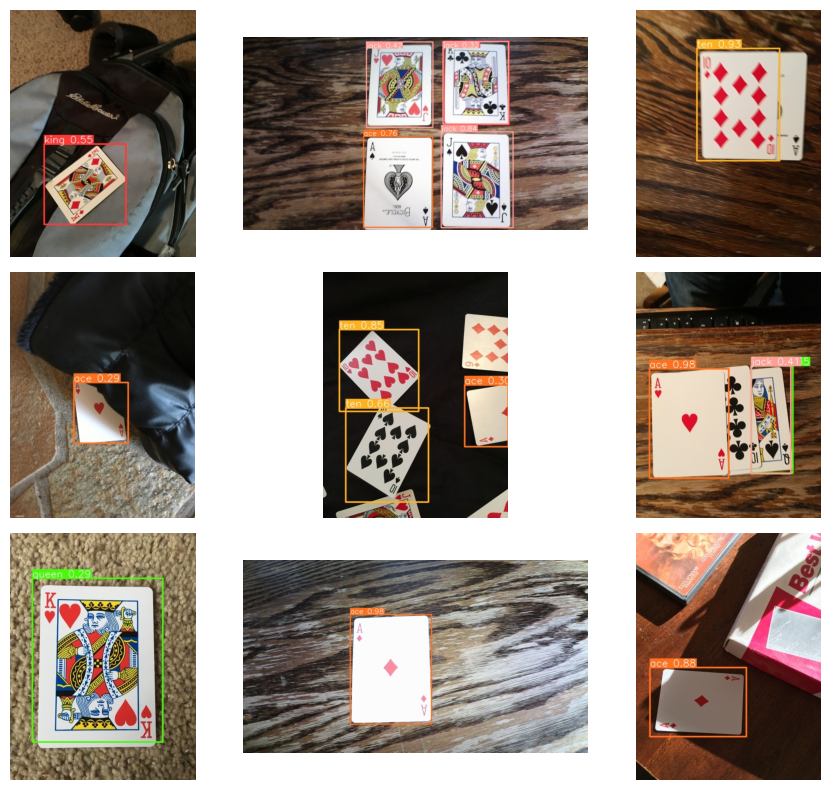

In [27]:
fig, axes = plt.subplots(
        3, 3, figsize=(10, 8), dpi=100
    )
for i, ax in enumerate(axes.reshape(-1)):
    ax.axis(False)
    result = str(test_ds.__get_raw_item__(i)[0].split("/")[-1])
    path = "runs/detect/yolov8n_custom2/" + result             # put YOUR path to the outputs here
    img = Image.open(path)
    ax.imshow(img)
fig.tight_layout()
plt.show()